In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import re
import numpy as np
from keras.models import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight

In [15]:
from gensim import models

In [16]:
df_train = pd.read_csv("/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/data/splited_data/processed_train.csv")
df_val = pd.read_csv("/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/data/splited_data/processed_val.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/data/splited_data/processed_test.csv")

In [17]:
df_val

,data,stayingpower,texture,smell,price,others,colour,shipping,packing,processed_data
0,"Son màu lên siu đẹp giá lại hạt dẻ, cho shop 5...",0,-1,-1,2,-1,2,-1,-1,son màu lên siu đẹp giá lại hạt_dẻ cho shop 5 ...
1,Son mịn lắm á bôi lên thì hơi khô thôi nói chu...,-1,1,-1,2,-1,-1,-1,-1,son mịn lắm á bôi lên thì hơi khô thôi nói_chu...
2,Xinh đều màu giao hàng nhanh fjfiidkxsksososxk...,-1,-1,-1,-1,-1,2,2,-1,xinh đều màu giao hàng nhanh
3,Công dụng: Màu siêu xinh luôn nha\nKết cấu: Tô...,2,2,-1,-1,-1,2,-1,-1,công_dụng màu siêu xinh luôn nha kết_cấu tô lê...
4,Đóng gói hàng cẩn thận. Giao nhanh. Màu son nà...,-1,-1,-1,-1,-1,2,2,2,đóng gói hàng cẩn_thận giao nhanh màu son này ...
...,...,...,...,...,...,...,...,...,...,...
1580,"Hàng giao hơi lâu, chất son okeee lên màu đẹp....",-1,-1,-1,2,-1,2,0,-1,hàng giao hơi lâu chất son oke lên màu đẹp với...
1581,"Son cực đẹp, màu lên tự nhiên, thơm, đóng gói ...",-1,-1,2,-1,-1,2,-1,2,son cực đẹp màu lên tự_nhiên thơm đóng_gói chắ...
1582,"Màu son đẹp, bền, đóng gói sản phẩm kĩ lưỡng. ...",2,-1,-1,-1,-1,2,-1,-1,màu son đẹp bền đóng_gói sản_phẩm kĩ_lưỡng mua...
1583,"Màu rất đẹp, chất son rất mướt. Lên môi khá là...",2,2,-1,2,-1,2,-1,-1,màu rất đẹp chất son rất mướt lên môi khá là m...


In [18]:
cmt_train = df_train['processed_data'].astype('str').values
cmt_val = df_val['processed_data'].astype('str').values
cmt_test = df_test['processed_data'].astype('str').values

## Load label

In [19]:
label_sentiment_train = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_sentiment_train.pkl', 'rb'))
label_sentiment_val = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_sentiment_val.pkl', 'rb'))
label_sentiment_test = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_sentiment_test.pkl', 'rb'))


In [20]:
label_aspect_train = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_is_aspect_train.pkl', 'rb'))
label_aspect_val = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_is_aspect_val.pkl', 'rb'))
label_aspect_test = pickle.load(open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/Label/label_approach_2_is_aspect_test.pkl', 'rb'))


In [21]:
label_aspect_train.shape

(12644, 8)

In [22]:
def get_label(label_dict):
  return label_dict['colour'], label_dict['others'],\
  label_dict['packing'], label_dict['price'], label_dict['shiping'],\
  label_dict['smell'], label_dict['stayingpower'], label_dict['texture']

 

In [23]:
color_train, others_train, packing_train, price_train,\
shipping_train, smell_train, stayingpower_train, texture_train = get_label(label_sentiment_train)

color_val, others_val, packing_val, price_val,\
shipping_val, smell_val, stayingpower_val, texture_val = get_label(label_sentiment_val)

color_test, others_test, packing_test, price_test,\
shipping_test, smell_test, stayingpower_test, texture_test = get_label(label_sentiment_test)


# Create word embedding matrix

In [24]:
w2v_path = '/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/word2vec/elmo_embeddings_large.txt'
w2c_model = models.KeyedVectors.load_word2vec_format(w2v_path, binary = False)

In [25]:
vocab =  w2c_model.wv.vocab
word_vec_dict = {}

for word in vocab:
  word_vec_dict[word] = w2c_model.get_vector(word)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [26]:

tok = Tokenizer(filters='')
tok.fit_on_texts(cmt_train)
tok.fit_on_texts(cmt_val)
tok.fit_on_texts(cmt_test)
vocab_size = len(tok.word_index)+1

tokenized_train = tok.texts_to_sequences(cmt_train)
tokenized_val = tok.texts_to_sequences(cmt_val)
tokenized_test = tok.texts_to_sequences(cmt_test)

In [27]:
print(vocab_size)

9708


In [28]:
max_len = 115
embed_dim = 1024

padded_train = pad_sequences(tokenized_train, padding = 'post', maxlen = max_len)
padded_val = pad_sequences(tokenized_val, padding = 'post', maxlen = max_len)
padded_test = pad_sequences(tokenized_test, padding = 'post', maxlen = max_len)
padded_train

array([[  1,   3, 914, ...,   0,   0,   0],
       [  1,   3,   7, ...,   0,   0,   0],
       [  1,   2,  10, ...,   0,   0,   0],
       ...,
       [  1,  22,  23, ...,   0,   0,   0],
       [  5,   4,  11, ...,   0,   0,   0],
       [  1,   3,   7, ...,   0,   0,   0]], dtype=int32)

In [29]:
padded_train.shape

(12644, 115)

In [30]:
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))

for word, i in tok.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:
      embed_matrix[i] = embed_vector
        

In [31]:
embed_matrix.shape

(9708, 1024)

# Model building

## BiLSTM

In [32]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 8
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)
lstm = Bidirectional(LSTM(units = 200, activation = 'tanh'))(embed)
dense2 = Dense(units = 128, activation = 'relu')(lstm)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


out_smell = Dense(units = 4, activation = 'softmax', name = 'out_smell')(tf.concat([tf.gather(out_aspect, [0], axis=1), dense4], axis = 1))
out_texture = Dense(units = 4, activation = 'softmax', name = 'out_texture')(tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis = 1))
out_color = Dense(units = 4, activation = 'softmax', name = 'out_color')(tf.concat([tf.gather(out_aspect, [2], axis=1), dense4], axis = 1))
out_price = Dense(units = 4, activation = 'softmax', name = 'out_price')(tf.concat([tf.gather(out_aspect, [3], axis=1), dense4], axis = 1))
out_shipping = Dense(units = 4, activation = 'softmax', name = 'out_shipping')(tf.concat([tf.gather(out_aspect, [4], axis=1), dense4], axis = 1))
out_packing = Dense(units = 4, activation = 'softmax', name = 'out_packing')(tf.concat([tf.gather(out_aspect, [5], axis=1), dense4], axis = 1))
out_stayingpower = Dense(units = 4, activation = 'softmax', name = 'out_stayingpower')(tf.concat([tf.gather(out_aspect, [6], axis=1), dense4], axis = 1))


model = tf.keras.Model(inputs = input, outputs = [out_aspect,
                                                  out_smell, out_texture, out_color, out_price,
                                                  out_shipping, out_packing, out_stayingpower])


In [33]:
losses = {
  "out_aspect": "binary_crossentropy",
	"out_smell": "categorical_crossentropy",
	"out_texture": "categorical_crossentropy",
  "out_color": "categorical_crossentropy",
  "out_price": "categorical_crossentropy",
  "out_shipping": "categorical_crossentropy",
  "out_packing": "categorical_crossentropy",
  "out_stayingpower": "categorical_crossentropy",
}

In [34]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=losses, metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 115)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 115, 1024)    9940992     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 400)          1960000     ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 128)          51328       ['bidirectional[0][0]']          
                                                                                              

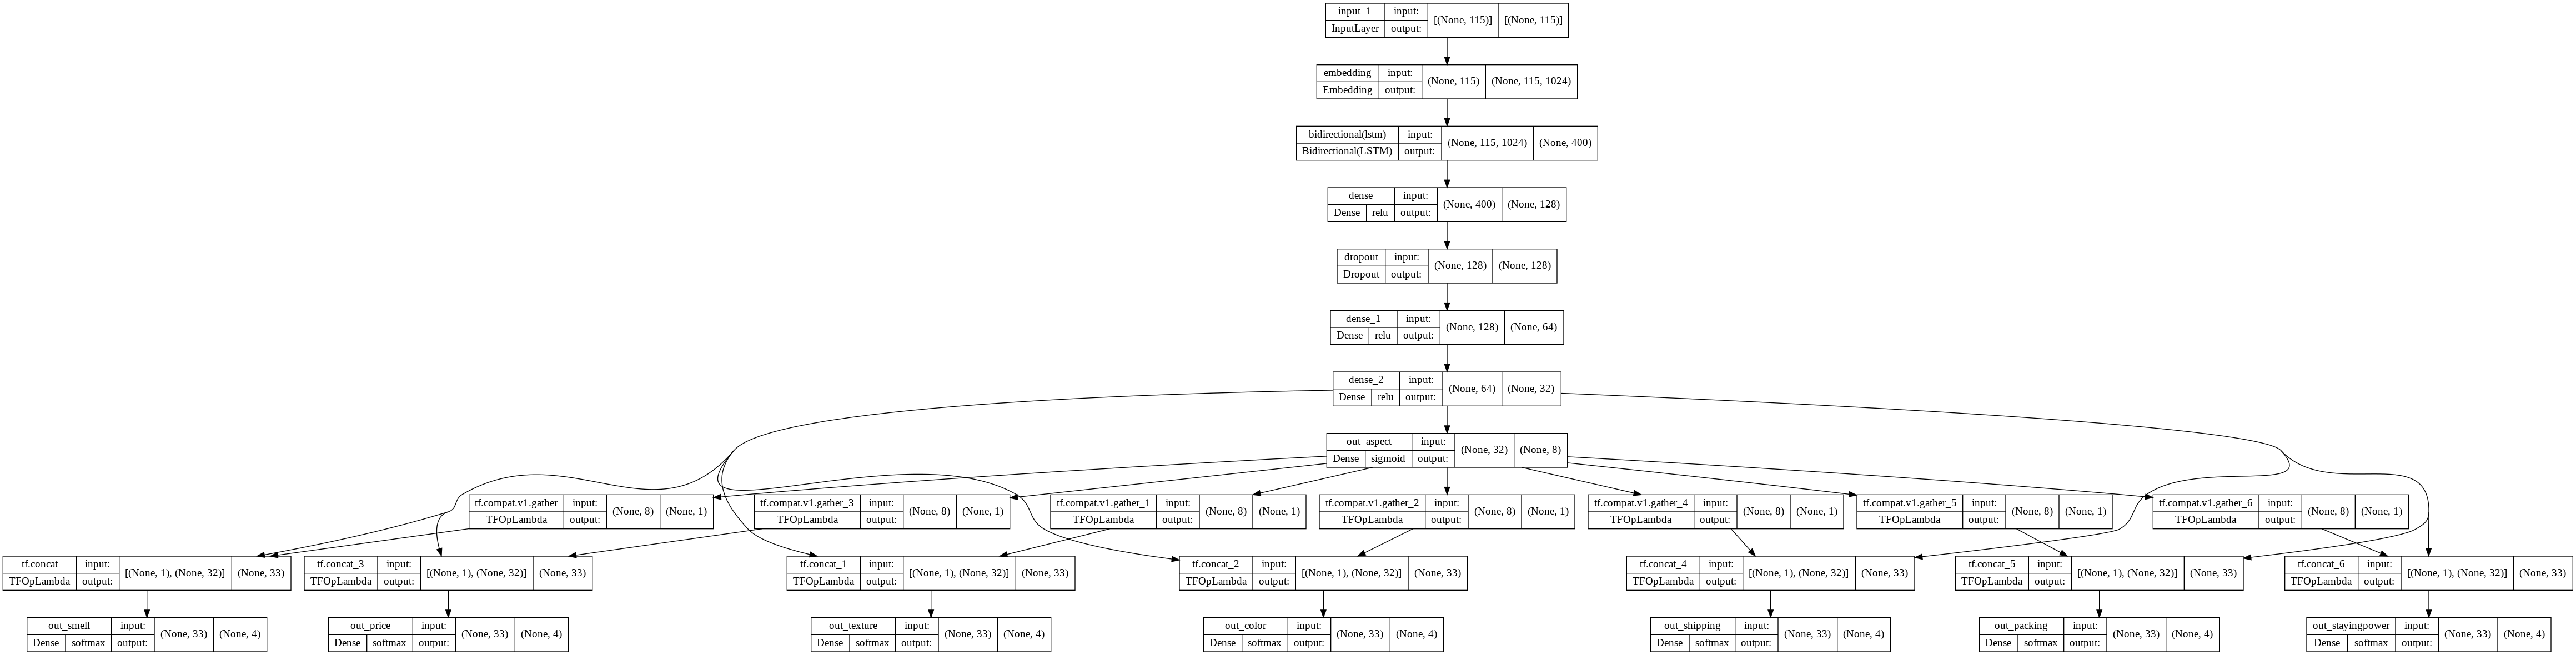

In [35]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [37]:
# Fit model

history = model.fit(x=padded_train,
	y={"out_aspect": label_aspect_train, "out_smell": smell_train, "out_texture": texture_train, "out_color": color_train,
    "out_price": price_train, "out_shipping": shipping_train, "out_packing": packing_train,
    "out_stayingpower": stayingpower_train},

	validation_data=(padded_val,
		{"out_aspect": label_aspect_val, "out_smell": smell_val, "out_texture": texture_val, "out_color": color_val,
    "out_price": price_val, "out_shipping": shipping_val, "out_packing": packing_val,
    "out_stayingpower": stayingpower_val}),
	batch_size = 128,
	epochs=70,
	callbacks = [callback],
	verbose=1)

Epoch 1/70
99/99 [==============================] - 15s 84ms/step - loss: 8.0263 - out_aspect_loss: 0.7647 - out_smell_loss: 0.8377 - out_texture_loss: 1.0531 - out_color_loss: 1.2446 - out_price_loss: 0.8420 - out_shipping_loss: 1.2305 - out_packing_loss: 1.1047 - out_stayingpower_loss: 0.9490 - out_aspect_acc: 0.1291 - out_smell_acc: 0.6779 - out_texture_acc: 0.5221 - out_color_acc: 0.3535 - out_price_acc: 0.7334 - out_shipping_acc: 0.3610 - out_packing_acc: 0.7020 - out_stayingpower_acc: 0.6342 - val_loss: 6.0997 - val_out_aspect_loss: 0.7366 - val_out_smell_loss: 0.6181 - val_out_texture_loss: 0.8279 - val_out_color_loss: 0.9040 - val_out_price_loss: 0.6076 - val_out_shipping_loss: 0.8954 - val_out_packing_loss: 0.8946 - val_out_stayingpower_loss: 0.6157 - val_out_aspect_acc: 0.1937 - val_out_smell_acc: 0.8088 - val_out_texture_acc: 0.7161 - val_out_color_acc: 0.7306 - val_out_price_acc: 0.7962 - val_out_shipping_acc: 0.7287 - val_out_packing_acc: 0.8006 - val_out_stayingpower_acc:

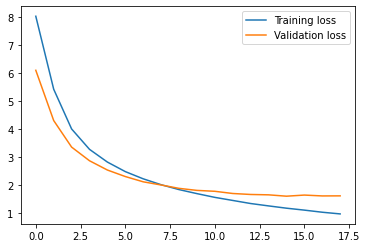

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

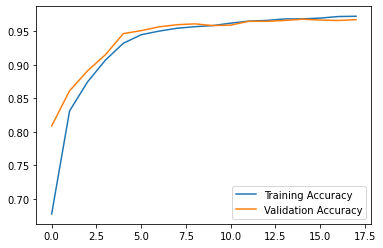

In [39]:
plt.plot(history.history['out_smell_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_smell_acc'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [40]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

In [41]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['smell', 'texture', 'colour', 'price',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_test_result.txt'.format(model_type), "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))
    
    elif data_eval == 'eval':
        with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_val_result.txt'.format(model_type), "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [42]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm')

In [43]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [44]:
pred_smell_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_texture_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_colour_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))
pred_price_test = np.where(np.argmax(pred_test[4], axis = 1)==3, -1, np.argmax(pred_test[4], axis = 1))
pred_shipping_test = np.where(np.argmax(pred_test[5], axis = 1)==3, -1, np.argmax(pred_test[5], axis = 1))
pred_packing_test = np.where(np.argmax(pred_test[6], axis = 1)==3, -1, np.argmax(pred_test[6], axis = 1))
pred_stayingpower_test = np.where(np.argmax(pred_test[7], axis = 1)==3, -1, np.argmax(pred_test[7], axis = 1))

In [45]:
pred_smell_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_texture_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_colour_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))
pred_price_val = np.where(np.argmax(pred_val[4], axis = 1)==3, -1, np.argmax(pred_val[4], axis = 1))
pred_shipping_val = np.where(np.argmax(pred_val[5], axis = 1)==3, -1, np.argmax(pred_val[5], axis = 1))
pred_packing_val = np.where(np.argmax(pred_val[6], axis = 1)==3, -1, np.argmax(pred_val[6], axis = 1))
pred_stayingpower_val = np.where(np.argmax(pred_val[7], axis = 1)==3, -1, np.argmax(pred_val[7], axis = 1))



In [46]:
predict_dict_test = {'smell':pred_smell_test, 'texture':pred_texture_test, 'colour': pred_colour_test,
                'price': pred_price_test, 'shipping': pred_shipping_test, 'packing': pred_packing_test,
                'stayingpower': pred_stayingpower_test}
predict_dict_val = {'smell':pred_smell_val, 'texture':pred_texture_val, 'colour': pred_colour_val,
                'price': pred_price_val, 'shipping': pred_shipping_val, 'packing': pred_packing_val,
                'stayingpower': pred_stayingpower_val}

In [47]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_test[i], predict_dict_test[i]))
  print("-----------------------------------")


smell

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1265
           0       0.72      0.60      0.66        48
           1       0.00      0.00      0.00        16
           2       0.88      0.91      0.90       252

    accuracy                           0.96      1581
   macro avg       0.65      0.63      0.64      1581
weighted avg       0.95      0.96      0.96      1581

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       854
           0       0.59      0.30      0.40        54
           1       0.26      0.12      0.16        51
           2       0.87      0.95      0.91       622

    accuracy                           0.91      1581
   macro avg       0.67      0.58      0.61      1581
weighted avg       0.90      0.91      0.90      1581

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [48]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_val[i], predict_dict_val[i]))
  print("-----------------------------------")

smell

              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      1282
           0       0.70      0.60      0.65        52
           1       0.50      0.08      0.13        13
           2       0.88      0.94      0.91       238

    accuracy                           0.97      1585
   macro avg       0.77      0.65      0.67      1585
weighted avg       0.96      0.97      0.96      1585

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97       831
           0       0.58      0.53      0.55        53
           1       0.31      0.09      0.14        53
           2       0.89      0.93      0.91       648

    accuracy                           0.91      1585
   macro avg       0.69      0.63      0.64      1585
weighted avg       0.90      0.91      0.90      1585

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [49]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_test_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_test[i], predict_dict_test[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [50]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_val_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_val[i],  predict_dict_val[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## BiGRU

In [51]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 8
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)
lstm = Bidirectional(GRU(units = 200, activation = 'tanh'))(embed)
dense2 = Dense(units = 128, activation = 'relu')(lstm)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


out_smell = Dense(units = 4, activation = 'softmax', name = 'out_smell')(tf.concat([tf.gather(out_aspect, [0], axis=1), dense4], axis = 1))
out_texture = Dense(units = 4, activation = 'softmax', name = 'out_texture')(tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis = 1))
out_color = Dense(units = 4, activation = 'softmax', name = 'out_color')(tf.concat([tf.gather(out_aspect, [2], axis=1), dense4], axis = 1))
out_price = Dense(units = 4, activation = 'softmax', name = 'out_price')(tf.concat([tf.gather(out_aspect, [3], axis=1), dense4], axis = 1))
out_shipping = Dense(units = 4, activation = 'softmax', name = 'out_shipping')(tf.concat([tf.gather(out_aspect, [4], axis=1), dense4], axis = 1))
out_packing = Dense(units = 4, activation = 'softmax', name = 'out_packing')(tf.concat([tf.gather(out_aspect, [5], axis=1), dense4], axis = 1))
out_stayingpower = Dense(units = 4, activation = 'softmax', name = 'out_stayingpower')(tf.concat([tf.gather(out_aspect, [6], axis=1), dense4], axis = 1))


model = tf.keras.Model(inputs = input, outputs = [out_aspect,
                                                  out_smell, out_texture, out_color, out_price,
                                                  out_shipping, out_packing, out_stayingpower])


In [52]:
losses = {
  "out_aspect": "binary_crossentropy",
	"out_smell": "categorical_crossentropy",
	"out_texture": "categorical_crossentropy",
  "out_color": "categorical_crossentropy",
  "out_price": "categorical_crossentropy",
  "out_shipping": "categorical_crossentropy",
  "out_packing": "categorical_crossentropy",
  "out_stayingpower": "categorical_crossentropy",
}

In [53]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=losses, metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 115)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 115, 1024)    9940992     ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 400)         1471200     ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 dense_3 (Dense)                (None, 128)          51328       ['bidirectional_1[0][0]']  

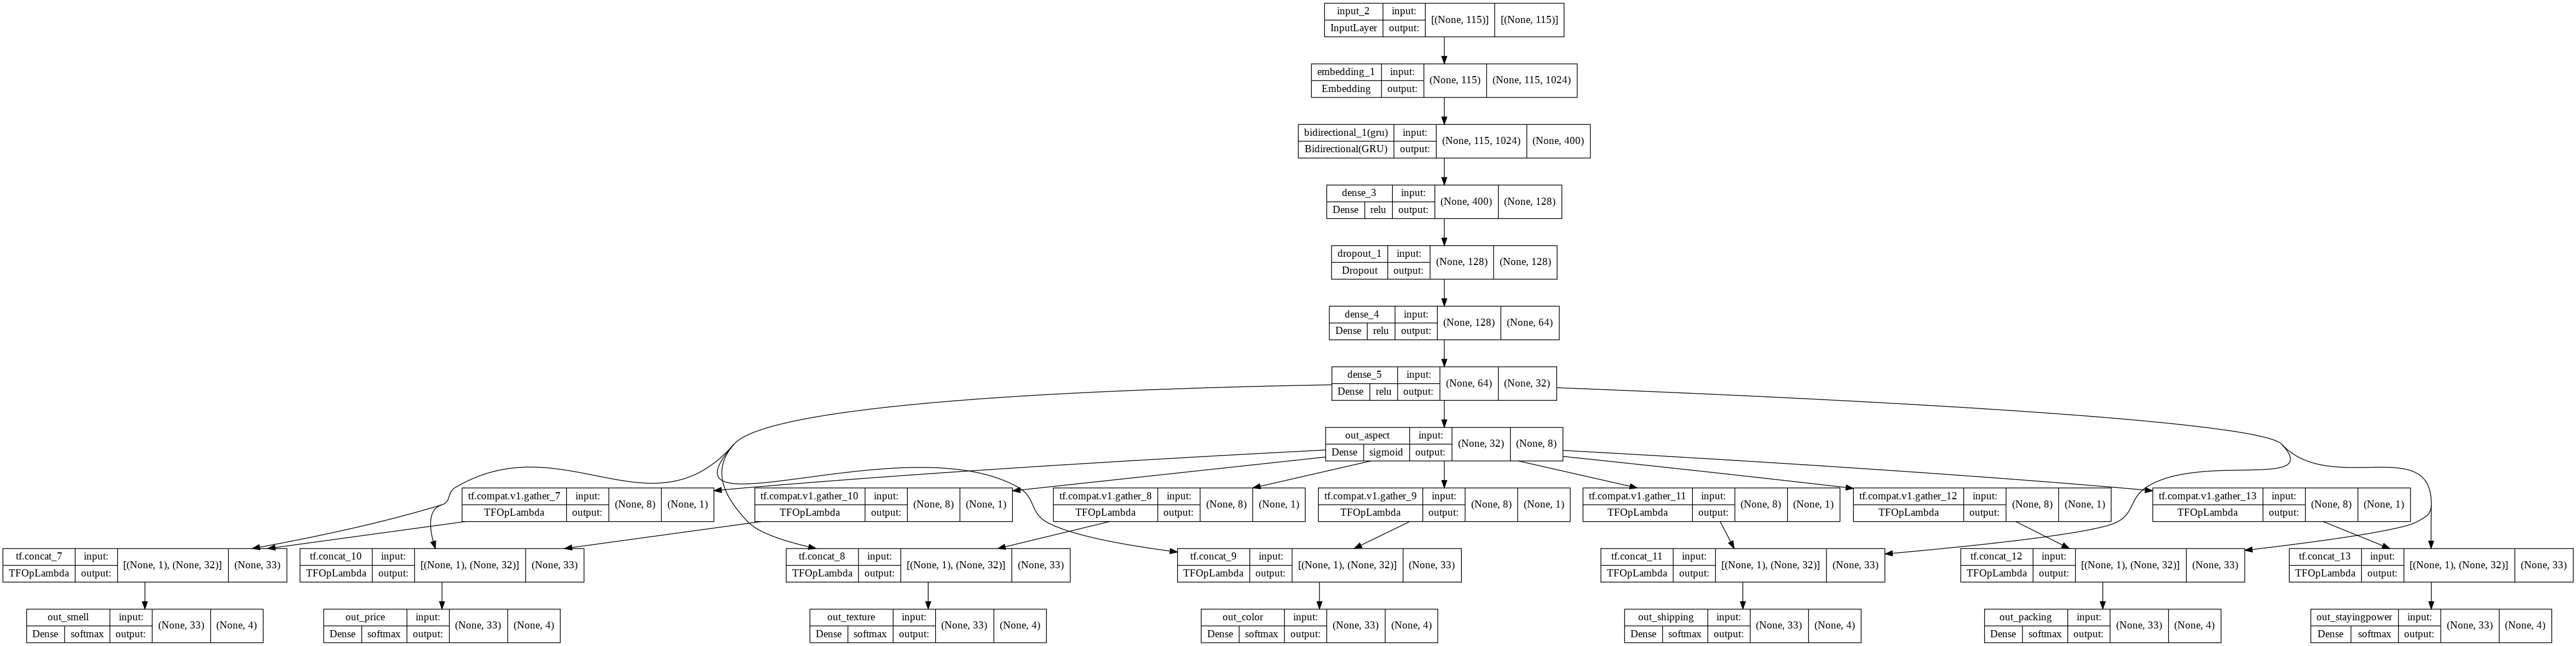

In [54]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [55]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [56]:
# Fit model

history = model.fit(x=padded_train,
	y={"out_aspect": label_aspect_train, "out_smell": smell_train, "out_texture": texture_train, "out_color": color_train,
    "out_price": price_train, "out_shipping": shipping_train, "out_packing": packing_train,
    "out_stayingpower": stayingpower_train},

	validation_data=(padded_val,
		{"out_aspect": label_aspect_val, "out_smell": smell_val, "out_texture": texture_val, "out_color": color_val,
    "out_price": price_val, "out_shipping": shipping_val, "out_packing": packing_val,
    "out_stayingpower": stayingpower_val}),
	batch_size = 128,
	epochs=70,
	callbacks = [callback],
	verbose=1)

Epoch 1/70
99/99 [==============================] - 12s 77ms/step - loss: 8.1543 - out_aspect_loss: 0.7616 - out_smell_loss: 0.9022 - out_texture_loss: 1.0315 - out_color_loss: 1.0668 - out_price_loss: 1.1022 - out_shipping_loss: 1.1910 - out_packing_loss: 1.0495 - out_stayingpower_loss: 1.0495 - out_aspect_acc: 0.0114 - out_smell_acc: 0.7278 - out_texture_acc: 0.5974 - out_color_acc: 0.5672 - out_price_acc: 0.6348 - out_shipping_acc: 0.4470 - out_packing_acc: 0.6129 - out_stayingpower_acc: 0.6798 - val_loss: 6.1578 - val_out_aspect_loss: 0.8006 - val_out_smell_loss: 0.7482 - val_out_texture_loss: 0.7926 - val_out_color_loss: 0.8427 - val_out_price_loss: 0.7251 - val_out_shipping_loss: 0.9915 - val_out_packing_loss: 0.5928 - val_out_stayingpower_loss: 0.6643 - val_out_aspect_acc: 0.0063 - val_out_smell_acc: 0.8088 - val_out_texture_acc: 0.7539 - val_out_color_acc: 0.6965 - val_out_price_acc: 0.7962 - val_out_shipping_acc: 0.7091 - val_out_packing_acc: 0.8019 - val_out_stayingpower_acc:

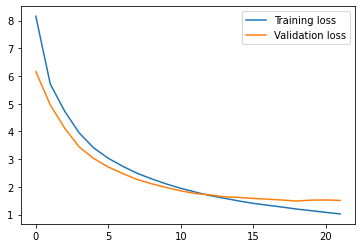

In [57]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

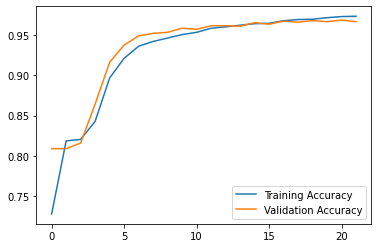

In [58]:
plt.plot(history.history['out_smell_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_smell_acc'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [59]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

In [60]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['smell', 'texture', 'colour', 'price',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_test_result.txt'.format(model_type), "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))
    
    elif data_eval == 'eval':
        with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_val_result.txt'.format(model_type), "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [61]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bigru')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bigru')

In [62]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [63]:
pred_smell_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_texture_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_colour_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))
pred_price_test = np.where(np.argmax(pred_test[4], axis = 1)==3, -1, np.argmax(pred_test[4], axis = 1))
pred_shipping_test = np.where(np.argmax(pred_test[5], axis = 1)==3, -1, np.argmax(pred_test[5], axis = 1))
pred_packing_test = np.where(np.argmax(pred_test[6], axis = 1)==3, -1, np.argmax(pred_test[6], axis = 1))
pred_stayingpower_test = np.where(np.argmax(pred_test[7], axis = 1)==3, -1, np.argmax(pred_test[7], axis = 1))

In [64]:
pred_smell_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_texture_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_colour_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))
pred_price_val = np.where(np.argmax(pred_val[4], axis = 1)==3, -1, np.argmax(pred_val[4], axis = 1))
pred_shipping_val = np.where(np.argmax(pred_val[5], axis = 1)==3, -1, np.argmax(pred_val[5], axis = 1))
pred_packing_val = np.where(np.argmax(pred_val[6], axis = 1)==3, -1, np.argmax(pred_val[6], axis = 1))
pred_stayingpower_val = np.where(np.argmax(pred_val[7], axis = 1)==3, -1, np.argmax(pred_val[7], axis = 1))



In [65]:
predict_dict_test = {'smell':pred_smell_test, 'texture':pred_texture_test, 'colour': pred_colour_test,
                'price': pred_price_test, 'shipping': pred_shipping_test, 'packing': pred_packing_test,
                'stayingpower': pred_stayingpower_test}
predict_dict_val = {'smell':pred_smell_val, 'texture':pred_texture_val, 'colour': pred_colour_val,
                'price': pred_price_val, 'shipping': pred_shipping_val, 'packing': pred_packing_val,
                'stayingpower': pred_stayingpower_val}

In [66]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_test[i], predict_dict_test[i]))
  print("-----------------------------------")


smell

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1265
           0       0.56      0.52      0.54        48
           1       0.00      0.00      0.00        16
           2       0.88      0.91      0.89       252

    accuracy                           0.96      1581
   macro avg       0.61      0.61      0.61      1581
weighted avg       0.95      0.96      0.95      1581

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       854
           0       0.50      0.39      0.44        54
           1       0.44      0.08      0.13        51
           2       0.87      0.93      0.90       622

    accuracy                           0.91      1581
   macro avg       0.69      0.59      0.61      1581
weighted avg       0.89      0.91      0.89      1581

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [67]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_val[i], predict_dict_val[i]))
  print("-----------------------------------")

smell

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1282
           0       0.63      0.52      0.57        52
           1       0.00      0.00      0.00        13
           2       0.87      0.95      0.91       238

    accuracy                           0.97      1585
   macro avg       0.62      0.62      0.62      1585
weighted avg       0.96      0.97      0.96      1585

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       831
           0       0.42      0.40      0.41        53
           1       0.22      0.04      0.06        53
           2       0.89      0.91      0.90       648

    accuracy                           0.90      1585
   macro avg       0.62      0.58      0.58      1585
weighted avg       0.88      0.90      0.89      1585

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [68]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bigru_test_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_test[i], predict_dict_test[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [69]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bigru_val_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_val[i],  predict_dict_val[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## BiLSTM+CONV

In [70]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 8
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(LSTM(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

avg_pool1 = GlobalAveragePooling1D()(conv)
max_pool1 = GlobalMaxPooling1D()(conv)
    
    
concat = Concatenate(axis=-1)([avg_pool1, max_pool1])

dense2 = Dense(units = 128, activation = 'relu')(concat)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


out_smell = Dense(units = 4, activation = 'softmax', name = 'out_smell')(tf.concat([tf.gather(out_aspect, [0], axis=1), dense4], axis = 1))
out_texture = Dense(units = 4, activation = 'softmax', name = 'out_texture')(tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis = 1))
out_color = Dense(units = 4, activation = 'softmax', name = 'out_color')(tf.concat([tf.gather(out_aspect, [2], axis=1), dense4], axis = 1))
out_price = Dense(units = 4, activation = 'softmax', name = 'out_price')(tf.concat([tf.gather(out_aspect, [3], axis=1), dense4], axis = 1))
out_shipping = Dense(units = 4, activation = 'softmax', name = 'out_shipping')(tf.concat([tf.gather(out_aspect, [4], axis=1), dense4], axis = 1))
out_packing = Dense(units = 4, activation = 'softmax', name = 'out_packing')(tf.concat([tf.gather(out_aspect, [5], axis=1), dense4], axis = 1))
out_stayingpower = Dense(units = 4, activation = 'softmax', name = 'out_stayingpower')(tf.concat([tf.gather(out_aspect, [6], axis=1), dense4], axis = 1))


model = tf.keras.Model(inputs = input, outputs = [out_aspect,
                                                  out_smell, out_texture, out_color, out_price,
                                                  out_shipping, out_packing, out_stayingpower])


In [71]:
losses = {
  "out_aspect": "binary_crossentropy",
	"out_smell": "categorical_crossentropy",
	"out_texture": "categorical_crossentropy",
  "out_color": "categorical_crossentropy",
  "out_price": "categorical_crossentropy",
  "out_shipping": "categorical_crossentropy",
  "out_packing": "categorical_crossentropy",
  "out_stayingpower": "categorical_crossentropy",
}

In [72]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=losses, metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 115)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 115, 1024)    9940992     ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 115, 1024)   0           ['embedding_2[0][0]']            
 out1D)                                                                                           
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 115, 400)    1960000     ['spatial_dropout1d[0][0]']

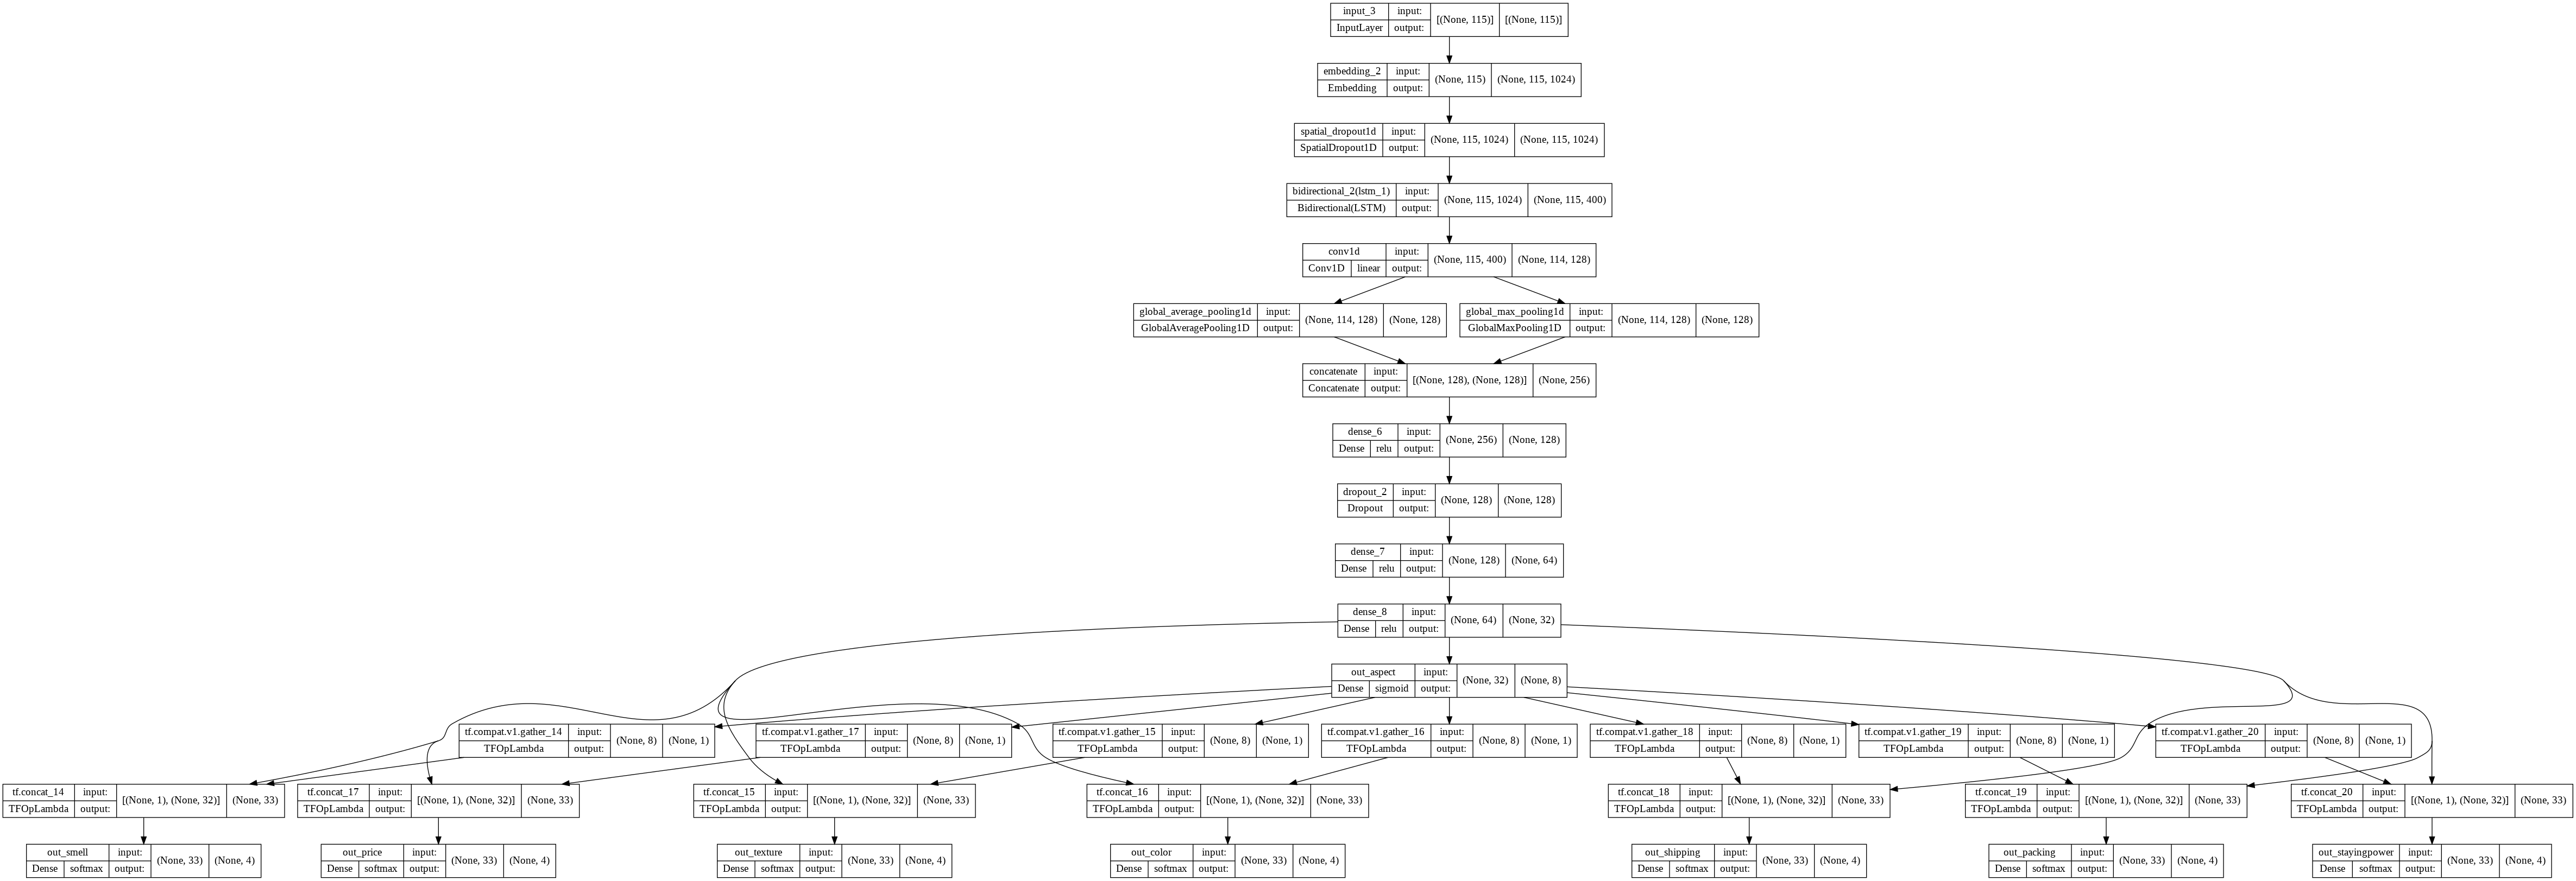

In [73]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [74]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [75]:
# Fit model

history = model.fit(x=padded_train,
	y={"out_aspect": label_aspect_train, "out_smell": smell_train, "out_texture": texture_train, "out_color": color_train,
    "out_price": price_train, "out_shipping": shipping_train, "out_packing": packing_train,
    "out_stayingpower": stayingpower_train},

	validation_data=(padded_val,
		{"out_aspect": label_aspect_val, "out_smell": smell_val, "out_texture": texture_val, "out_color": color_val,
    "out_price": price_val, "out_shipping": shipping_val, "out_packing": packing_val,
    "out_stayingpower": stayingpower_val}),
	batch_size = 128,
	epochs=70,
	callbacks = [callback],
	verbose=1)

Epoch 1/70
99/99 [==============================] - 18s 96ms/step - loss: 7.7647 - out_aspect_loss: 0.8881 - out_smell_loss: 0.8848 - out_texture_loss: 1.2921 - out_color_loss: 1.0802 - out_price_loss: 0.8753 - out_shipping_loss: 1.0506 - out_packing_loss: 0.7362 - out_stayingpower_loss: 0.9576 - out_aspect_acc: 0.0180 - out_smell_acc: 0.6775 - out_texture_acc: 0.4248 - out_color_acc: 0.5676 - out_price_acc: 0.7105 - out_shipping_acc: 0.6435 - out_packing_acc: 0.7245 - out_stayingpower_acc: 0.7366 - val_loss: 6.0882 - val_out_aspect_loss: 0.9633 - val_out_smell_loss: 0.6370 - val_out_texture_loss: 1.0789 - val_out_color_loss: 0.7168 - val_out_price_loss: 0.5824 - val_out_shipping_loss: 0.8760 - val_out_packing_loss: 0.4921 - val_out_stayingpower_loss: 0.7417 - val_out_aspect_acc: 0.0063 - val_out_smell_acc: 0.8088 - val_out_texture_acc: 0.7148 - val_out_color_acc: 0.8732 - val_out_price_acc: 0.8309 - val_out_shipping_acc: 0.6864 - val_out_packing_acc: 0.8032 - val_out_stayingpower_acc:

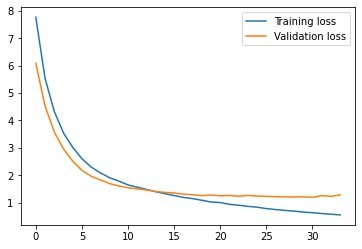

In [76]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

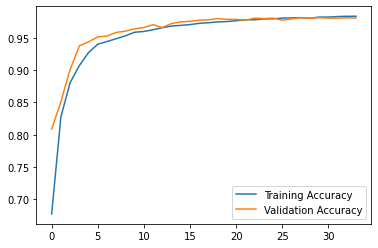

In [77]:
plt.plot(history.history['out_smell_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_smell_acc'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [78]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

In [79]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['smell', 'texture', 'colour', 'price',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_test_result.txt'.format(model_type), "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))
    
    elif data_eval == 'eval':
        with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_val_result.txt'.format(model_type), "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [80]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm_conv')

In [81]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [82]:
pred_smell_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_texture_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_colour_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))
pred_price_test = np.where(np.argmax(pred_test[4], axis = 1)==3, -1, np.argmax(pred_test[4], axis = 1))
pred_shipping_test = np.where(np.argmax(pred_test[5], axis = 1)==3, -1, np.argmax(pred_test[5], axis = 1))
pred_packing_test = np.where(np.argmax(pred_test[6], axis = 1)==3, -1, np.argmax(pred_test[6], axis = 1))
pred_stayingpower_test = np.where(np.argmax(pred_test[7], axis = 1)==3, -1, np.argmax(pred_test[7], axis = 1))

In [83]:
pred_smell_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_texture_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_colour_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))
pred_price_val = np.where(np.argmax(pred_val[4], axis = 1)==3, -1, np.argmax(pred_val[4], axis = 1))
pred_shipping_val = np.where(np.argmax(pred_val[5], axis = 1)==3, -1, np.argmax(pred_val[5], axis = 1))
pred_packing_val = np.where(np.argmax(pred_val[6], axis = 1)==3, -1, np.argmax(pred_val[6], axis = 1))
pred_stayingpower_val = np.where(np.argmax(pred_val[7], axis = 1)==3, -1, np.argmax(pred_val[7], axis = 1))



In [84]:
predict_dict_test = {'smell':pred_smell_test, 'texture':pred_texture_test, 'colour': pred_colour_test,
                'price': pred_price_test, 'shipping': pred_shipping_test, 'packing': pred_packing_test,
                'stayingpower': pred_stayingpower_test}
predict_dict_val = {'smell':pred_smell_val, 'texture':pred_texture_val, 'colour': pred_colour_val,
                'price': pred_price_val, 'shipping': pred_shipping_val, 'packing': pred_packing_val,
                'stayingpower': pred_stayingpower_val}

In [85]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_test[i], predict_dict_test[i]))
  print("-----------------------------------")


smell

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1265
           0       0.74      0.77      0.76        48
           1       0.00      0.00      0.00        16
           2       0.92      0.94      0.93       252

    accuracy                           0.97      1581
   macro avg       0.66      0.68      0.67      1581
weighted avg       0.96      0.97      0.97      1581

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.98      0.97      0.98       854
           0       0.68      0.59      0.63        54
           1       0.31      0.25      0.28        51
           2       0.92      0.95      0.94       622

    accuracy                           0.93      1581
   macro avg       0.72      0.69      0.71      1581
weighted avg       0.93      0.93      0.93      1581

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [86]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_val[i], predict_dict_val[i]))
  print("-----------------------------------")

smell

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1282
           0       0.85      0.77      0.81        52
           1       0.00      0.00      0.00        13
           2       0.92      0.99      0.95       238

    accuracy                           0.98      1585
   macro avg       0.69      0.69      0.69      1585
weighted avg       0.97      0.98      0.98      1585

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.96      0.98      0.97       831
           0       0.63      0.64      0.64        53
           1       0.43      0.28      0.34        53
           2       0.92      0.93      0.93       648

    accuracy                           0.92      1585
   macro avg       0.74      0.71      0.72      1585
weighted avg       0.92      0.92      0.92      1585

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [87]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_conv_test_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_test[i], predict_dict_test[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [88]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_conv_val_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_val[i],  predict_dict_val[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## BiGRU+CONV

In [89]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 8
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(GRU(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

avg_pool1 = GlobalAveragePooling1D()(conv)
max_pool1 = GlobalMaxPooling1D()(conv)
    
    
concat = Concatenate(axis=-1)([avg_pool1, max_pool1])

dense2 = Dense(units = 128, activation = 'relu')(concat)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


out_smell = Dense(units = 4, activation = 'softmax', name = 'out_smell')(tf.concat([tf.gather(out_aspect, [0], axis=1), dense4], axis = 1))
out_texture = Dense(units = 4, activation = 'softmax', name = 'out_texture')(tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis = 1))
out_color = Dense(units = 4, activation = 'softmax', name = 'out_color')(tf.concat([tf.gather(out_aspect, [2], axis=1), dense4], axis = 1))
out_price = Dense(units = 4, activation = 'softmax', name = 'out_price')(tf.concat([tf.gather(out_aspect, [3], axis=1), dense4], axis = 1))
out_shipping = Dense(units = 4, activation = 'softmax', name = 'out_shipping')(tf.concat([tf.gather(out_aspect, [4], axis=1), dense4], axis = 1))
out_packing = Dense(units = 4, activation = 'softmax', name = 'out_packing')(tf.concat([tf.gather(out_aspect, [5], axis=1), dense4], axis = 1))
out_stayingpower = Dense(units = 4, activation = 'softmax', name = 'out_stayingpower')(tf.concat([tf.gather(out_aspect, [6], axis=1), dense4], axis = 1))


model = tf.keras.Model(inputs = input, outputs = [out_aspect,
                                                  out_smell, out_texture, out_color, out_price,
                                                  out_shipping, out_packing, out_stayingpower])


In [90]:
losses = {
  "out_aspect": "binary_crossentropy",
	"out_smell": "categorical_crossentropy",
	"out_texture": "categorical_crossentropy",
  "out_color": "categorical_crossentropy",
  "out_price": "categorical_crossentropy",
  "out_shipping": "categorical_crossentropy",
  "out_packing": "categorical_crossentropy",
  "out_stayingpower": "categorical_crossentropy",
}

In [91]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=losses, metrics=['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 115)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 115, 1024)    9940992     ['input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 115, 1024)   0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 115, 400)    1471200     ['spatial_dropout1d_1[0][0]

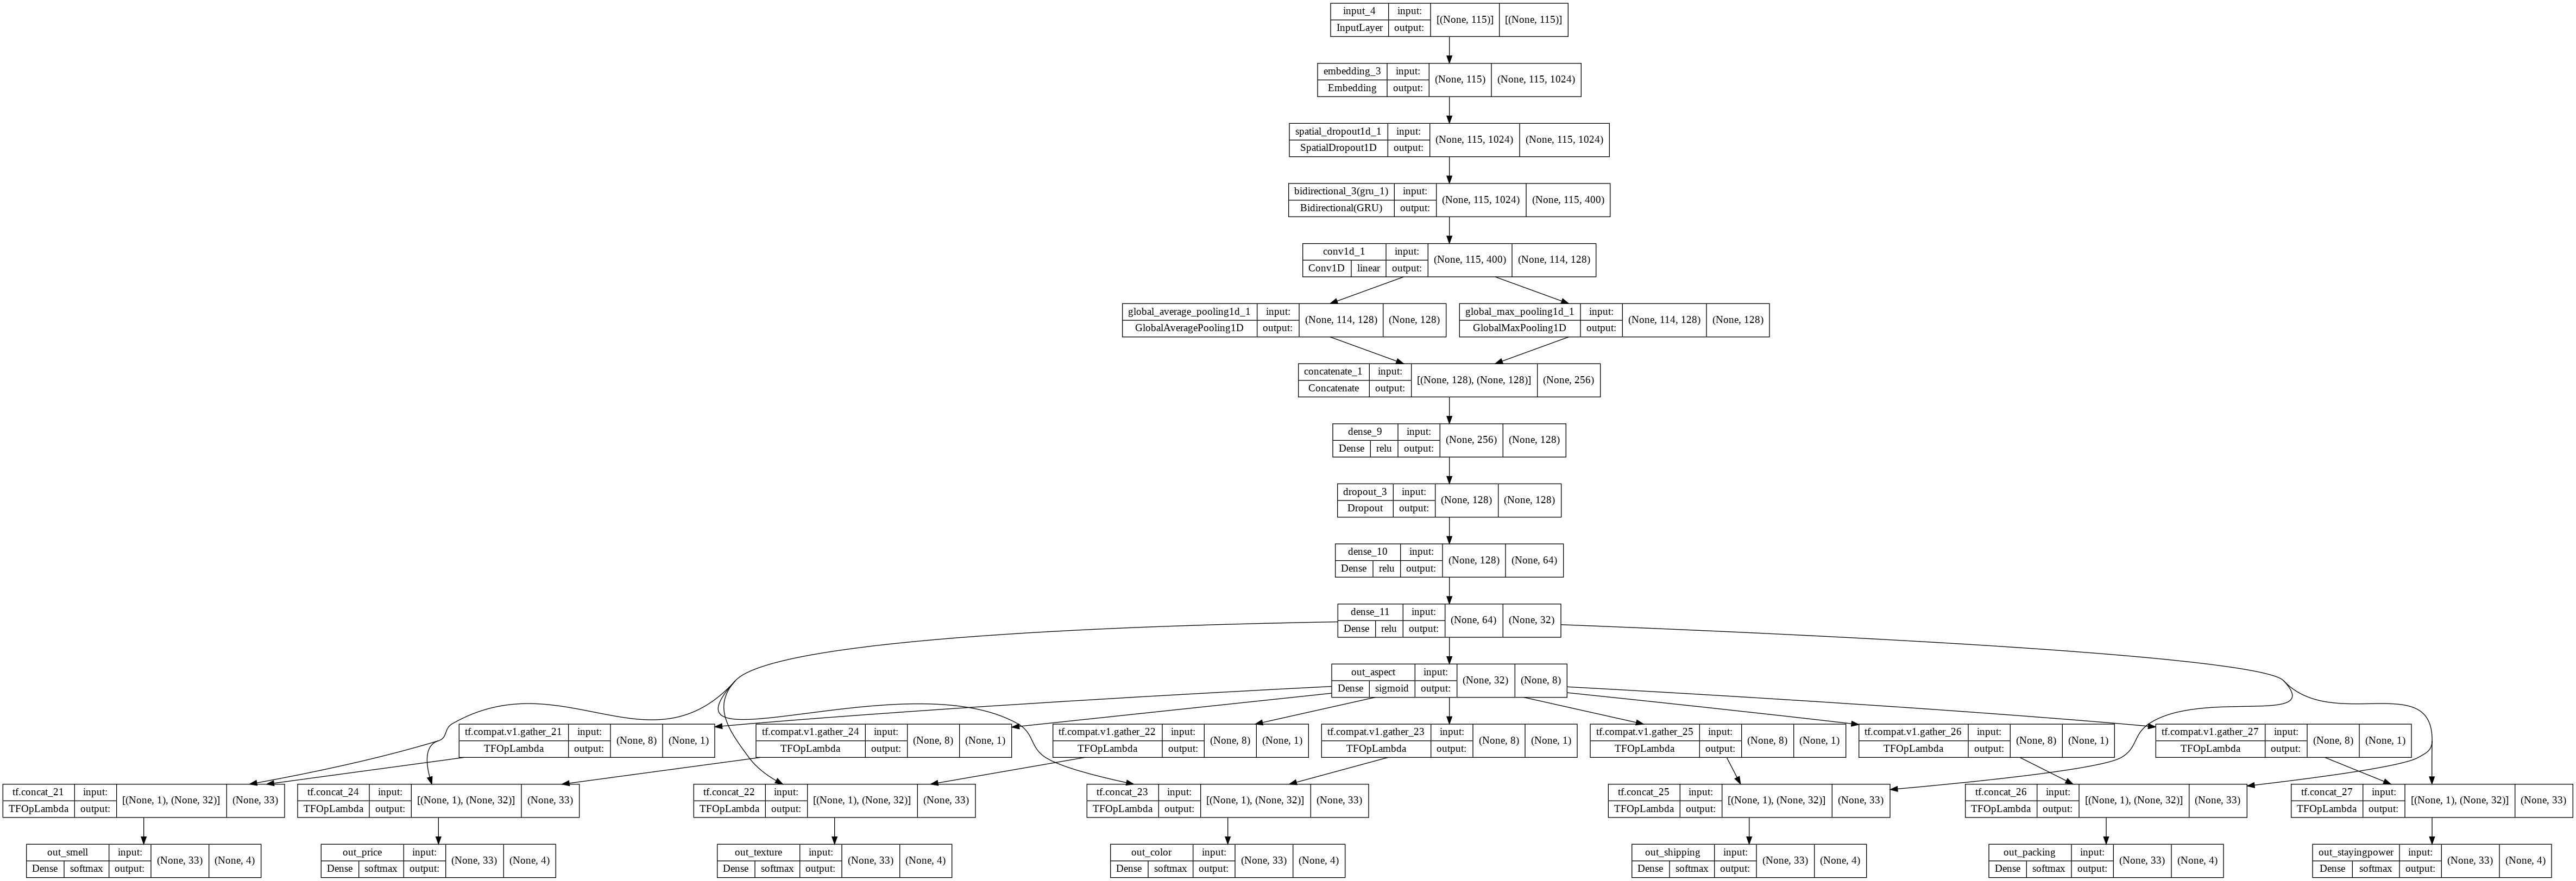

In [92]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [93]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [94]:
# Fit model

history = model.fit(x=padded_train,
	y={"out_aspect": label_aspect_train, "out_smell": smell_train, "out_texture": texture_train, "out_color": color_train,
    "out_price": price_train, "out_shipping": shipping_train, "out_packing": packing_train,
    "out_stayingpower": stayingpower_train},

	validation_data=(padded_val,
		{"out_aspect": label_aspect_val, "out_smell": smell_val, "out_texture": texture_val, "out_color": color_val,
    "out_price": price_val, "out_shipping": shipping_val, "out_packing": packing_val,
    "out_stayingpower": stayingpower_val}),
	batch_size = 128,
	epochs=70,
	callbacks = [callback],
	verbose=1)

Epoch 1/70
99/99 [==============================] - 14s 85ms/step - loss: 8.0448 - out_aspect_loss: 0.8468 - out_smell_loss: 0.9284 - out_texture_loss: 1.2302 - out_color_loss: 1.2618 - out_price_loss: 0.9105 - out_shipping_loss: 1.0446 - out_packing_loss: 0.8252 - out_stayingpower_loss: 0.9973 - out_aspect_acc: 0.0296 - out_smell_acc: 0.6947 - out_texture_acc: 0.4881 - out_color_acc: 0.4293 - out_price_acc: 0.6114 - out_shipping_acc: 0.5835 - out_packing_acc: 0.7793 - out_stayingpower_acc: 0.7260 - val_loss: 6.0130 - val_out_aspect_loss: 0.9265 - val_out_smell_loss: 0.6459 - val_out_texture_loss: 0.9519 - val_out_color_loss: 0.8821 - val_out_price_loss: 0.5192 - val_out_shipping_loss: 0.7606 - val_out_packing_loss: 0.5152 - val_out_stayingpower_loss: 0.8116 - val_out_aspect_acc: 0.0322 - val_out_smell_acc: 0.8088 - val_out_texture_acc: 0.7047 - val_out_color_acc: 0.7470 - val_out_price_acc: 0.8637 - val_out_shipping_acc: 0.7609 - val_out_packing_acc: 0.8076 - val_out_stayingpower_acc:

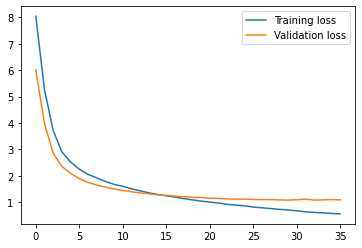

In [95]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

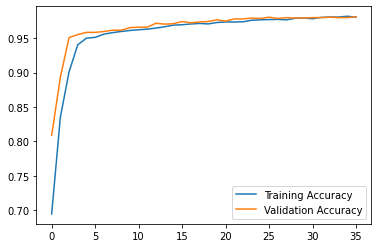

In [96]:
plt.plot(history.history['out_smell_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_smell_acc'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [97]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

In [98]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['smell', 'texture', 'colour', 'price',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_test_result.txt'.format(model_type), "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))
    
    elif data_eval == 'eval':
        with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_val_result.txt'.format(model_type), "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [99]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bigru_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bigru_conv')

In [100]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [101]:
pred_smell_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_texture_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_colour_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))
pred_price_test = np.where(np.argmax(pred_test[4], axis = 1)==3, -1, np.argmax(pred_test[4], axis = 1))
pred_shipping_test = np.where(np.argmax(pred_test[5], axis = 1)==3, -1, np.argmax(pred_test[5], axis = 1))
pred_packing_test = np.where(np.argmax(pred_test[6], axis = 1)==3, -1, np.argmax(pred_test[6], axis = 1))
pred_stayingpower_test = np.where(np.argmax(pred_test[7], axis = 1)==3, -1, np.argmax(pred_test[7], axis = 1))

In [102]:
pred_smell_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_texture_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_colour_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))
pred_price_val = np.where(np.argmax(pred_val[4], axis = 1)==3, -1, np.argmax(pred_val[4], axis = 1))
pred_shipping_val = np.where(np.argmax(pred_val[5], axis = 1)==3, -1, np.argmax(pred_val[5], axis = 1))
pred_packing_val = np.where(np.argmax(pred_val[6], axis = 1)==3, -1, np.argmax(pred_val[6], axis = 1))
pred_stayingpower_val = np.where(np.argmax(pred_val[7], axis = 1)==3, -1, np.argmax(pred_val[7], axis = 1))



In [103]:
predict_dict_test = {'smell':pred_smell_test, 'texture':pred_texture_test, 'colour': pred_colour_test,
                'price': pred_price_test, 'shipping': pred_shipping_test, 'packing': pred_packing_test,
                'stayingpower': pred_stayingpower_test}
predict_dict_val = {'smell':pred_smell_val, 'texture':pred_texture_val, 'colour': pred_colour_val,
                'price': pred_price_val, 'shipping': pred_shipping_val, 'packing': pred_packing_val,
                'stayingpower': pred_stayingpower_val}

In [104]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_test[i], predict_dict_test[i]))
  print("-----------------------------------")


smell

              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      1265
           0       0.71      0.88      0.79        48
           1       0.00      0.00      0.00        16
           2       0.94      0.94      0.94       252

    accuracy                           0.97      1581
   macro avg       0.66      0.70      0.68      1581
weighted avg       0.97      0.97      0.97      1581

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.98      0.97      0.98       854
           0       0.73      0.74      0.73        54
           1       0.39      0.22      0.28        51
           2       0.91      0.95      0.93       622

    accuracy                           0.93      1581
   macro avg       0.75      0.72      0.73      1581
weighted avg       0.92      0.93      0.93      1581

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [105]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_val[i], predict_dict_val[i]))
  print("-----------------------------------")

smell

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1282
           0       0.75      0.88      0.81        52
           1       1.00      0.08      0.14        13
           2       0.95      0.96      0.95       238

    accuracy                           0.98      1585
   macro avg       0.92      0.73      0.73      1585
weighted avg       0.98      0.98      0.98      1585

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.97      0.98      0.98       831
           0       0.72      0.77      0.75        53
           1       0.52      0.26      0.35        53
           2       0.93      0.94      0.94       648

    accuracy                           0.94      1585
   macro avg       0.78      0.74      0.75      1585
weighted avg       0.93      0.94      0.93      1585

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [106]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bigru_conv_test_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_test[i], predict_dict_test[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [107]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bigru_conv_val_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_val[i],  predict_dict_val[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## BiLSTM+BiGRU+CONV

In [108]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 8
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(LSTM(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv_lstm = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

gru = Bidirectional(GRU(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv_gru = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(gru)


avg_pool1 = GlobalAveragePooling1D()(conv_lstm)
max_pool1 = GlobalMaxPooling1D()(conv_lstm)

avg_pool2 = GlobalAveragePooling1D()(conv_gru)
max_pool2 = GlobalMaxPooling1D()(conv_gru)
    
    
concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])
dense1 = Dense(units = 256, activation = 'relu')(concat)
dense2 = Dense(units = 128, activation = 'relu')(dense1)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


out_smell = Dense(units = 4, activation = 'softmax', name = 'out_smell')(tf.concat([tf.gather(out_aspect, [0], axis=1), dense4], axis = 1))
out_texture = Dense(units = 4, activation = 'softmax', name = 'out_texture')(tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis = 1))
out_color = Dense(units = 4, activation = 'softmax', name = 'out_color')(tf.concat([tf.gather(out_aspect, [2], axis=1), dense4], axis = 1))
out_price = Dense(units = 4, activation = 'softmax', name = 'out_price')(tf.concat([tf.gather(out_aspect, [3], axis=1), dense4], axis = 1))
out_shipping = Dense(units = 4, activation = 'softmax', name = 'out_shipping')(tf.concat([tf.gather(out_aspect, [4], axis=1), dense4], axis = 1))
out_packing = Dense(units = 4, activation = 'softmax', name = 'out_packing')(tf.concat([tf.gather(out_aspect, [5], axis=1), dense4], axis = 1))
out_stayingpower = Dense(units = 4, activation = 'softmax', name = 'out_stayingpower')(tf.concat([tf.gather(out_aspect, [6], axis=1), dense4], axis = 1))


model = tf.keras.Model(inputs = input, outputs = [out_aspect,
                                                  out_smell, out_texture, out_color, out_price,
                                                  out_shipping, out_packing, out_stayingpower])


In [109]:
losses = {
  "out_aspect": "binary_crossentropy",
	"out_smell": "categorical_crossentropy",
	"out_texture": "categorical_crossentropy",
  "out_color": "categorical_crossentropy",
  "out_price": "categorical_crossentropy",
  "out_shipping": "categorical_crossentropy",
  "out_packing": "categorical_crossentropy",
  "out_stayingpower": "categorical_crossentropy",
}

In [110]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss=losses, metrics=['acc'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 115)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 115, 1024)    9940992     ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 115, 1024)   0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 115, 400)    1960000     ['spatial_dropout1d_2[0][0]

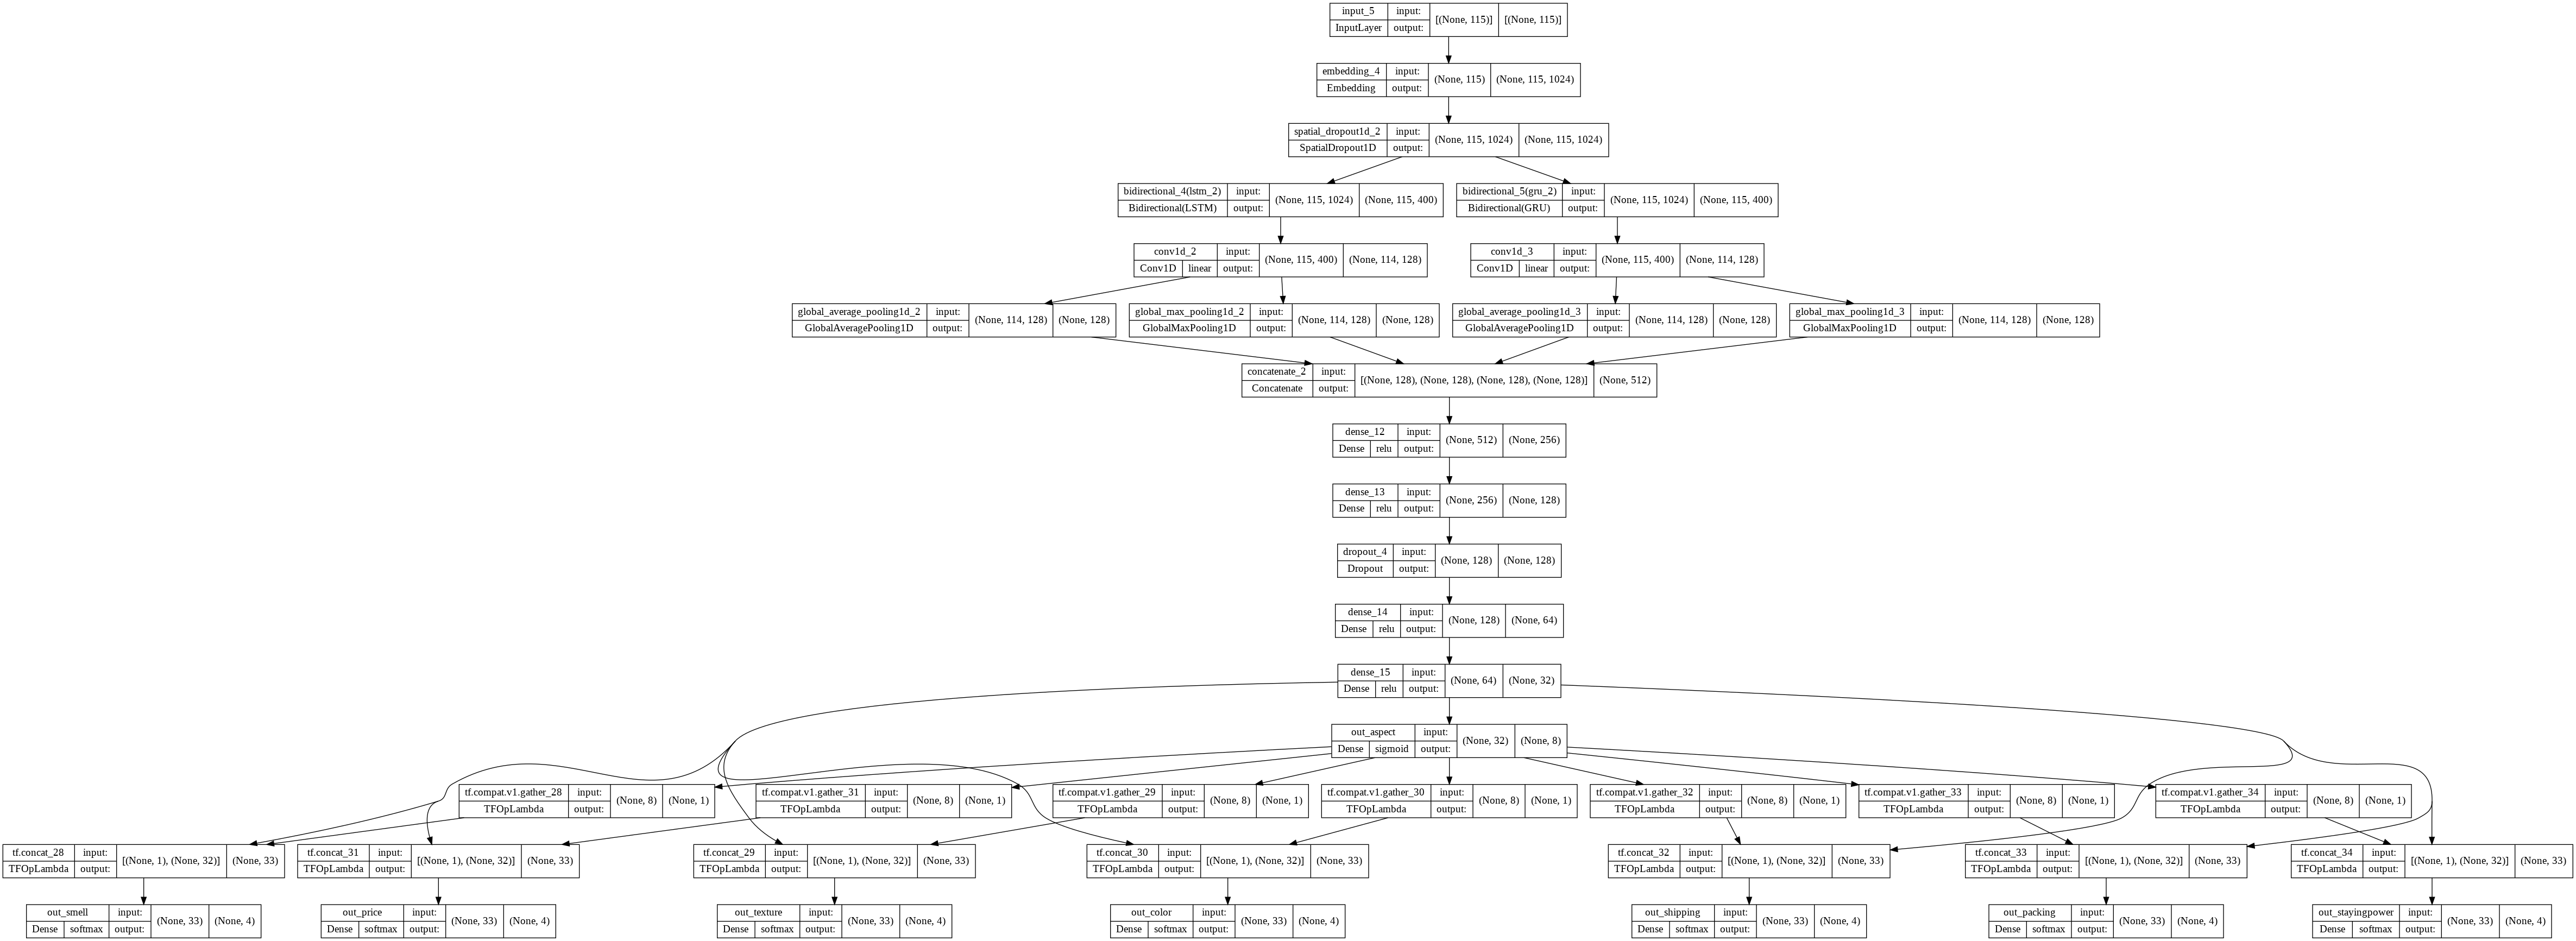

In [111]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [112]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [113]:
# Fit model

history = model.fit(x=padded_train,
	y={"out_aspect": label_aspect_train, "out_smell": smell_train, "out_texture": texture_train, "out_color": color_train,
    "out_price": price_train, "out_shipping": shipping_train, "out_packing": packing_train,
    "out_stayingpower": stayingpower_train},

	validation_data=(padded_val,
		{"out_aspect": label_aspect_val, "out_smell": smell_val, "out_texture": texture_val, "out_color": color_val,
    "out_price": price_val, "out_shipping": shipping_val, "out_packing": packing_val,
    "out_stayingpower": stayingpower_val}),
	batch_size = 128,
	epochs=70,
	callbacks = [callback],
	verbose=1)

Epoch 1/70
99/99 [==============================] - 24s 162ms/step - loss: 7.8478 - out_aspect_loss: 1.0236 - out_smell_loss: 0.7496 - out_texture_loss: 1.1515 - out_color_loss: 1.0276 - out_price_loss: 1.2408 - out_shipping_loss: 1.0492 - out_packing_loss: 0.7592 - out_stayingpower_loss: 0.8464 - out_aspect_acc: 0.1783 - out_smell_acc: 0.7991 - out_texture_acc: 0.4706 - out_color_acc: 0.5484 - out_price_acc: 0.5452 - out_shipping_acc: 0.6145 - out_packing_acc: 0.7414 - out_stayingpower_acc: 0.7822 - val_loss: 5.9552 - val_out_aspect_loss: 1.1050 - val_out_smell_loss: 0.5857 - val_out_texture_loss: 0.8678 - val_out_color_loss: 0.6842 - val_out_price_loss: 0.7851 - val_out_shipping_loss: 0.6791 - val_out_packing_loss: 0.5629 - val_out_stayingpower_loss: 0.6855 - val_out_aspect_acc: 0.1918 - val_out_smell_acc: 0.8088 - val_out_texture_acc: 0.7117 - val_out_color_acc: 0.8347 - val_out_price_acc: 0.7962 - val_out_shipping_acc: 0.7912 - val_out_packing_acc: 0.8259 - val_out_stayingpower_acc

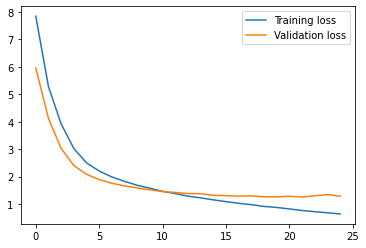

In [114]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

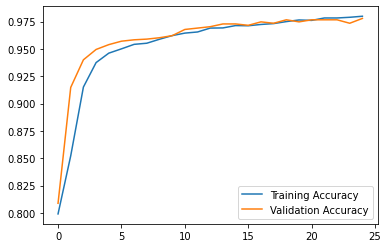

In [115]:
plt.plot(history.history['out_smell_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_smell_acc'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [116]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

In [117]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['smell', 'texture', 'colour', 'price',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_test_result.txt'.format(model_type), "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))
    
    elif data_eval == 'eval':
        with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_{}_aspect_val_result.txt'.format(model_type), "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [118]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm_bigru_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm_bigru_conv')

In [119]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [120]:
pred_smell_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_texture_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_colour_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))
pred_price_test = np.where(np.argmax(pred_test[4], axis = 1)==3, -1, np.argmax(pred_test[4], axis = 1))
pred_shipping_test = np.where(np.argmax(pred_test[5], axis = 1)==3, -1, np.argmax(pred_test[5], axis = 1))
pred_packing_test = np.where(np.argmax(pred_test[6], axis = 1)==3, -1, np.argmax(pred_test[6], axis = 1))
pred_stayingpower_test = np.where(np.argmax(pred_test[7], axis = 1)==3, -1, np.argmax(pred_test[7], axis = 1))

In [121]:
pred_smell_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_texture_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_colour_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))
pred_price_val = np.where(np.argmax(pred_val[4], axis = 1)==3, -1, np.argmax(pred_val[4], axis = 1))
pred_shipping_val = np.where(np.argmax(pred_val[5], axis = 1)==3, -1, np.argmax(pred_val[5], axis = 1))
pred_packing_val = np.where(np.argmax(pred_val[6], axis = 1)==3, -1, np.argmax(pred_val[6], axis = 1))
pred_stayingpower_val = np.where(np.argmax(pred_val[7], axis = 1)==3, -1, np.argmax(pred_val[7], axis = 1))



In [122]:
predict_dict_test = {'smell':pred_smell_test, 'texture':pred_texture_test, 'colour': pred_colour_test,
                'price': pred_price_test, 'shipping': pred_shipping_test, 'packing': pred_packing_test,
                'stayingpower': pred_stayingpower_test}
predict_dict_val = {'smell':pred_smell_val, 'texture':pred_texture_val, 'colour': pred_colour_val,
                'price': pred_price_val, 'shipping': pred_shipping_val, 'packing': pred_packing_val,
                'stayingpower': pred_stayingpower_val}

In [123]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_test[i], predict_dict_test[i]))
  print("-----------------------------------")


smell

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1265
           0       0.63      0.75      0.69        48
           1       0.00      0.00      0.00        16
           2       0.92      0.92      0.92       252

    accuracy                           0.97      1581
   macro avg       0.64      0.67      0.65      1581
weighted avg       0.96      0.97      0.96      1581

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.98      0.97      0.98       854
           0       0.65      0.59      0.62        54
           1       0.38      0.29      0.33        51
           2       0.92      0.96      0.94       622

    accuracy                           0.93      1581
   macro avg       0.73      0.70      0.72      1581
weighted avg       0.93      0.93      0.93      1581

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [124]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(df_val[i], predict_dict_val[i]))
  print("-----------------------------------")

smell

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1282
           0       0.78      0.75      0.76        52
           1       0.50      0.08      0.13        13
           2       0.93      0.97      0.95       238

    accuracy                           0.98      1585
   macro avg       0.80      0.70      0.71      1585
weighted avg       0.97      0.98      0.97      1585

-----------------------------------
colour

              precision    recall  f1-score   support

          -1       0.96      0.98      0.97       831
           0       0.68      0.68      0.68        53
           1       0.30      0.23      0.26        53
           2       0.93      0.93      0.93       648

    accuracy                           0.92      1585
   macro avg       0.72      0.70      0.71      1585
weighted avg       0.92      0.92      0.92      1585

-----------------------------------
stayingpower

              precision    re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [125]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_bigru_conv_test_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_test[i], predict_dict_test[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [126]:
list_aspect = ['smell', 'colour', 'stayingpower', 'price', 'shipping', 'packing', 'texture']
for i in list_aspect:
  with open('/content/drive/MyDrive/Final Project - Real Time Aspect-based Sentiment Classification/Notebooks/Linh/output_approach2/elmo_bilstm_bigru_conv_val_result.txt', "a") as dest:
    dest.write("Classification report for aspect: {} \n".format(i.upper()))
    dest.write(classification_report(df_val[i],  predict_dict_val[i]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat